In [55]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
import torch
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d
import matplotlib
matplotlib.rcParams.update({'font.size': 24, 'font.family': 'Helvetica', 'text.usetex': False})
%matplotlib inline

from utils.models import MLP
from utils.trainer import train_MLP
from utils.data import create_xor_dataset
from utils.plotting import plot_var, plot_task_rep, get_task_color, plot_3d_embedding

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


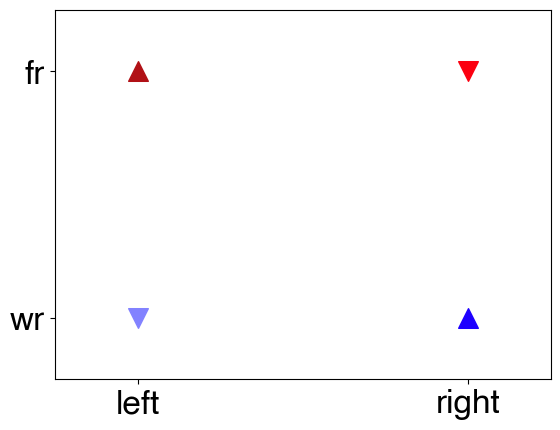

In [57]:
x1 = np.array ([-1., -1., 1., 1.], dtype = np.float32)
x2 = np.array ([-1., 1., -1., 1.], dtype = np.float32)
y_np  = np.array ([-1., 1., 1., -1.],dtype = np.float32)

X, y = create_xor_dataset(x1, x2, y_np, n_repeats=1, noise_lev=0)

fig = plot_task_rep(X, y)

In [58]:
n_epochs = 5000
dim_input = 2
dim_hidden = 500
dim_output = 1

lr = 2e-3
# Initialization scale
w1_inits = [0.0025, 0.25]
w2_init = 1/dim_hidden

init_models = []
trained_models = []

# Training
for w_i, w1_init in enumerate(w1_inits):
    # Model instantiation
    dlnn_model = MLP(dim_input, dim_hidden, dim_output, w1_init, w2_init)
    init_models.append(copy.deepcopy(dlnn_model))

    _, _, = train_MLP(dlnn_model, X, y, n_epochs=n_epochs, lr=lr)
    trained_models.append(dlnn_model)

In [59]:
rich_models = [init_models[0], trained_models[0]]
lazy_models = [init_models[-1], trained_models[-1]]

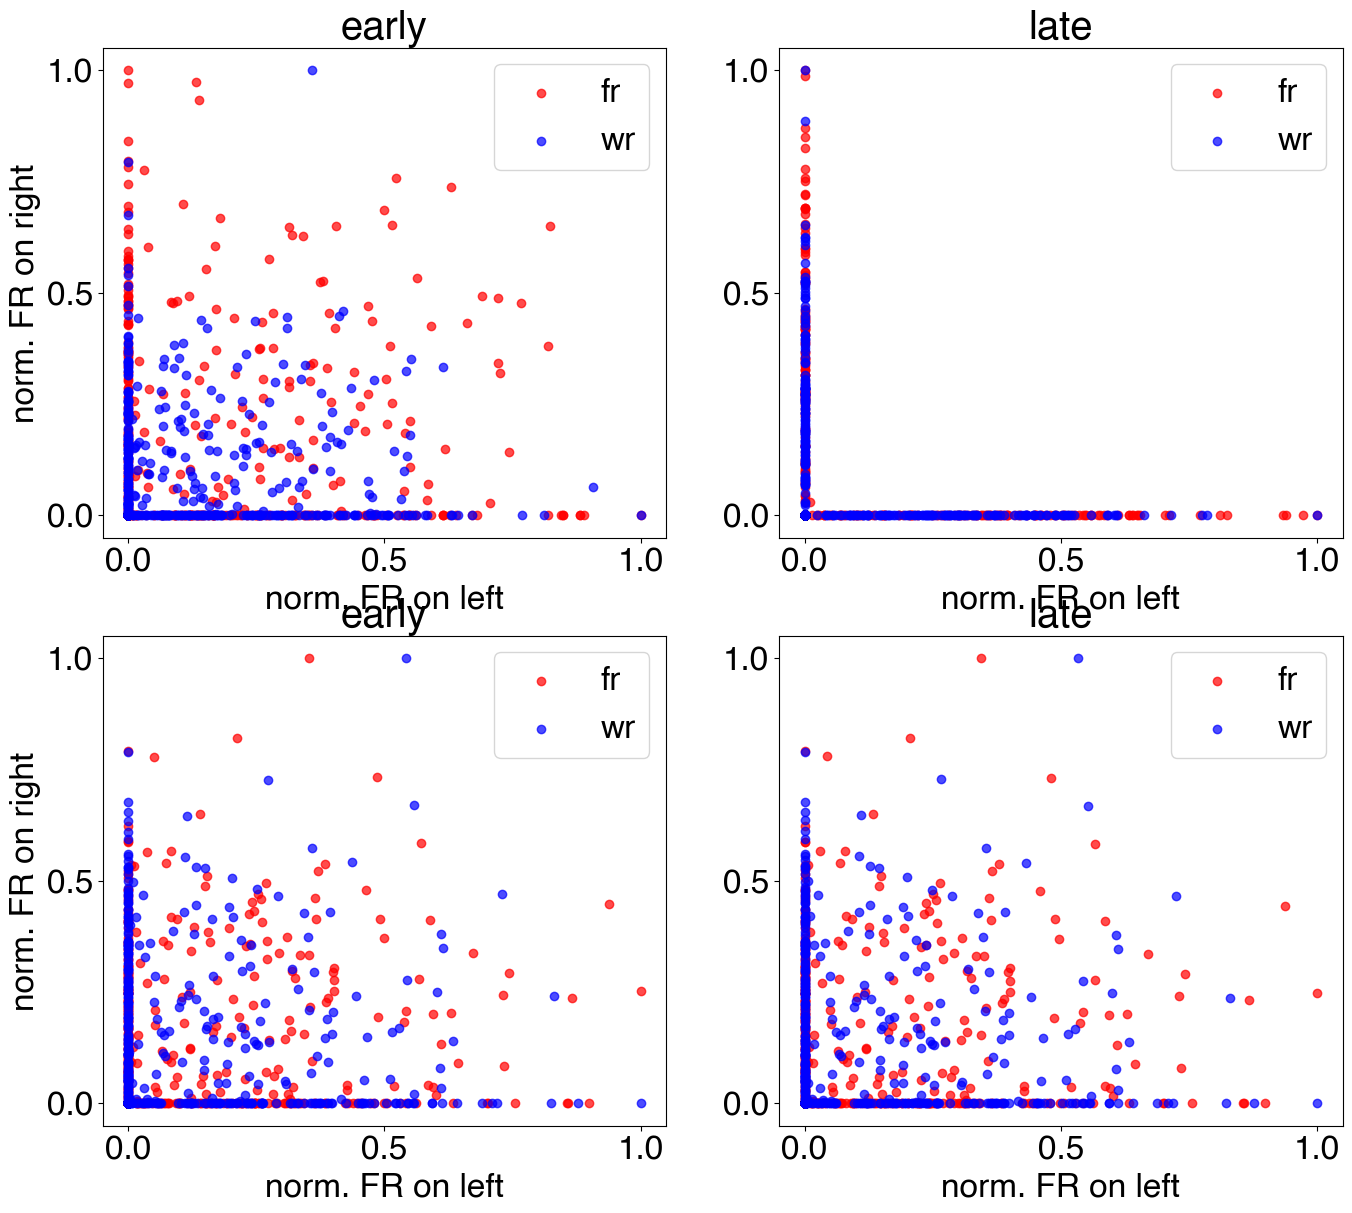

In [60]:
context_labels = ['fr', 'wr']
context_colors = ['red', 'blue']
arm_labels = ['left', 'right'] 
context_idx = [[1, 3], [0, 2]]

norm_hidden = np.zeros((4, 4, dim_hidden))

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 14)
for m_i, model in enumerate(rich_models + lazy_models):
    axis = axes.flatten()[m_i]
    
    _, hiddens = model(X)
    hidden_act = hiddens.detach().numpy()
    
    # norm_act_all = []
    for c_i, c_label in enumerate(context_labels):
        context_X = X[context_idx[c_i]]
    
        _, hiddens = model(context_X)
        hidden_act = hiddens.detach().numpy()
        # norm_act = [stats.zscore(act) for act in hidden_act]
        norm_act = [(act - act.min()) / (act.max() - act.min()) for act in hidden_act]
        # m, b = np.polyfit(norm_act[0], norm_act[1], 1)
        norm_act_all.append(norm_act)
        
        # norm_act_diff = np.mean(np.abs(norm_act[0] - norm_act[1]))
        # axis.hist(norm_act[0] - norm_act[1], label=c_label)
        # axis.set_xlabel('FR diff. between L and R')
        # axis.set_ylabel('count')
        # axis.legend()
        
        norm_hidden[m_i, context_idx[c_i], :] = norm_act
        axis.scatter(norm_act[0], norm_act[1], color=context_colors[c_i], alpha=0.7, label=c_label)
        
    # norm_act_all_concat = np.concatenate(norm_act_all, 1)
    # corr = stats.pearsonr(norm_act_all_concat[0], norm_act_all_concat[1]).statistic
    
    axis.set_xticks([0, 0.5, 1])
    axis.set_yticks([0, 0.5, 1])
    axis.set_xlabel('norm. FR on left')
    if m_i % 2 == 0:
        axis.set_ylabel('norm. FR on right')
    axis.legend()

    if m_i % 2 == 0:
        axis.set_title(f'early')
    else:
        axis.set_title(f'late')
            
# fig.savefig("rich_lazy_splitting.svg")

/Users/mac/Projects/replay_task_rep/simulations/utils/plotting.py:114: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axis.scatter(X[i, 0], X[i, 1], X[i, 2], c=colors[i], marker=marker, s=200)


Text(0.5, 0.92, 'dist(L, R) = 6.02')

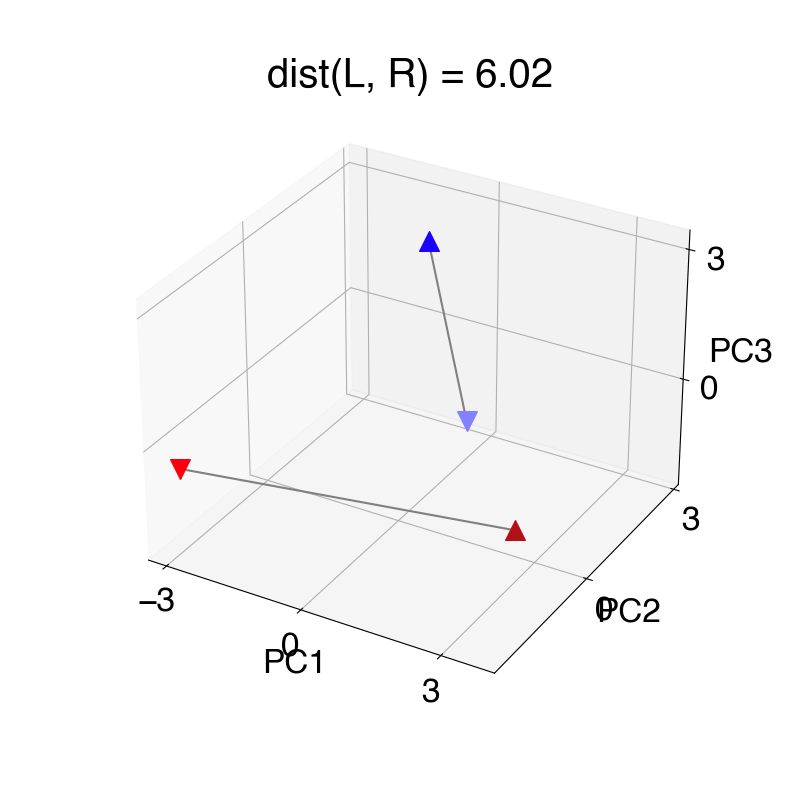

In [65]:
%matplotlib ipympl

rich_norm_hidden = norm_hidden[1]

# scaler = StandardScaler()
# rich_norm_hidden = scaler.fit_transform(rich_norm_hidden)

pca = PCA(n_components=3)
rich_embed_hidden = pca.fit_transform(rich_norm_hidden)

rich_pairwise_pca = pairwise_distances(rich_embed_hidden, metric='euclidean')
# print(rich_pairwise_pca)
rich_dist_LR = np.mean([rich_pairwise_pca[c_l, c_r] for c_l, c_r in context_idx])

fig, axis = plot_3d_embedding(X, y, rich_embed_hidden)
for l_i, r_i in context_idx:
    left_embed = rich_embed_hidden[l_i]
    right_embed = rich_embed_hidden[r_i]
    axis.plot([left_embed[0], right_embed[0]],
              [left_embed[1], right_embed[1]],
              zs=[left_embed[2], right_embed[2]],
              color='grey')

axis.set_title(f'dist(L, R) = {rich_dist_LR:.2f}')

In [52]:
# fig.savefig("rich_embedding.svg")

/Users/mac/Projects/replay_task_rep/simulations/utils/plotting.py:114: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axis.scatter(X[i, 0], X[i, 1], X[i, 2], c=colors[i], marker=marker, s=200)


Text(0.5, 0.92, 'dist(L, R) = 5.71')

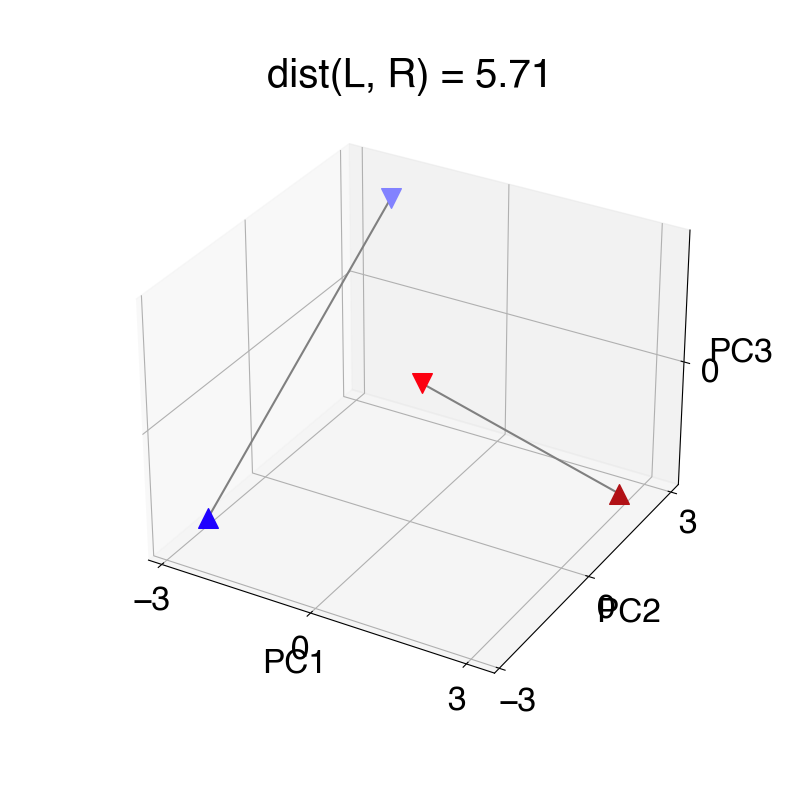

In [63]:
%matplotlib ipympl

lazy_norm_hidden = norm_hidden[3]

# scaler = StandardScaler()
# lazy_norm_hidden = scaler.fit_transform(lazy_norm_hidden)

pca = PCA(n_components=3)
lazy_embed_hidden = pca.fit_transform(lazy_norm_hidden)

lazy_pairwise_pca = pairwise_distances(lazy_embed_hidden, metric='euclidean')
# print(lazy_pairwise_pca)
lazy_dist_LR = np.mean([lazy_pairwise_pca[c_l, c_r] for c_l, c_r in context_idx])


fig, axis = plot_3d_embedding(X, y, lazy_embed_hidden)
for l_i, r_i in context_idx:
    left_embed = lazy_embed_hidden[l_i]
    right_embed = lazy_embed_hidden[r_i]
    axis.plot([left_embed[0], right_embed[0]],
              [left_embed[1], right_embed[1]],
              zs=[left_embed[2], right_embed[2]],
              color='grey')
    
axis.set_title(f'dist(L, R) = {lazy_dist_LR:.2f}')

In [64]:
# fig.savefig("lazy_embedding.svg")